In [24]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import shap
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
import time
import joblib

In [25]:
import sklearn
print(sklearn.__version__)

1.6.1


In [26]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
data_path = "/content/Churn_Modelling.csv"
df = pd.read_csv(data_path)
print("Dataset loaded successfully.")

Dataset loaded successfully.


In [28]:
# Perform initial data analysis
print("\n### Dataset Analysis ###")
print("Dataset Shape:", df.shape)
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


### Dataset Analysis ###
Dataset Shape: (10002, 14)

Missing Values:
RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

Duplicate Rows: 2


In [29]:
# Drop unnecessary columns
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [30]:
# Handle missing values and duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

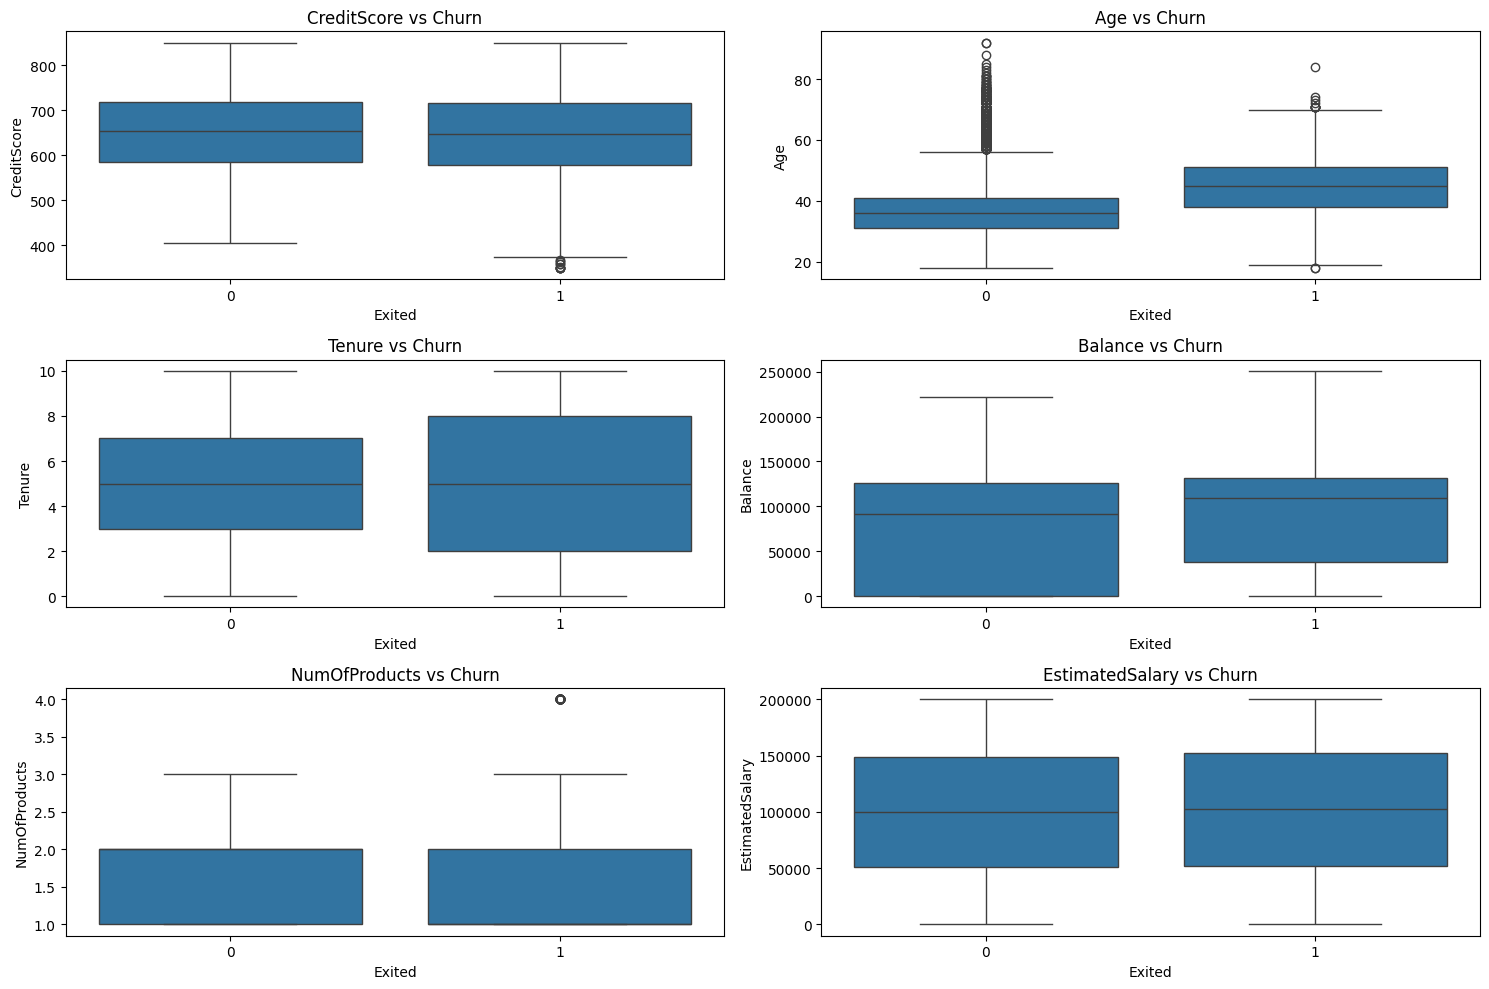

In [31]:
# Boxplot to detect outliers in numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()


### Number of Outliers in Each Feature ###
CreditScore: 16 outliers
Age: 359 outliers
Tenure: 0 outliers
Balance: 0 outliers
NumOfProducts: 60 outliers
EstimatedSalary: 0 outliers


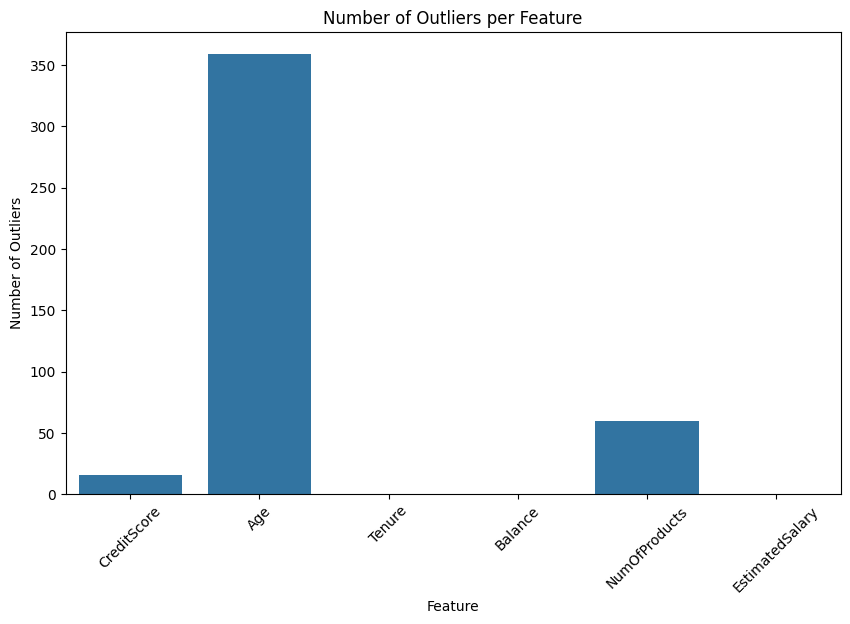

In [32]:
# Function to calculate outliers using IQR method
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

# Numerical columns to check for outliers
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Dictionary to store outlier counts
outlier_counts = {}

# Calculate outliers for each feature
print("\n### Number of Outliers in Each Feature ###")
for col in numerical_cols:
    outlier_count = count_outliers(df, col)
    outlier_counts[col] = outlier_count
    print(f"{col}: {outlier_count} outliers")

# Optional: Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(outlier_counts.keys()), y=list(outlier_counts.values()))
plt.title("Number of Outliers per Feature")
plt.xlabel("Feature")
plt.ylabel("Number of Outliers")
plt.xticks(rotation=45)
plt.show()

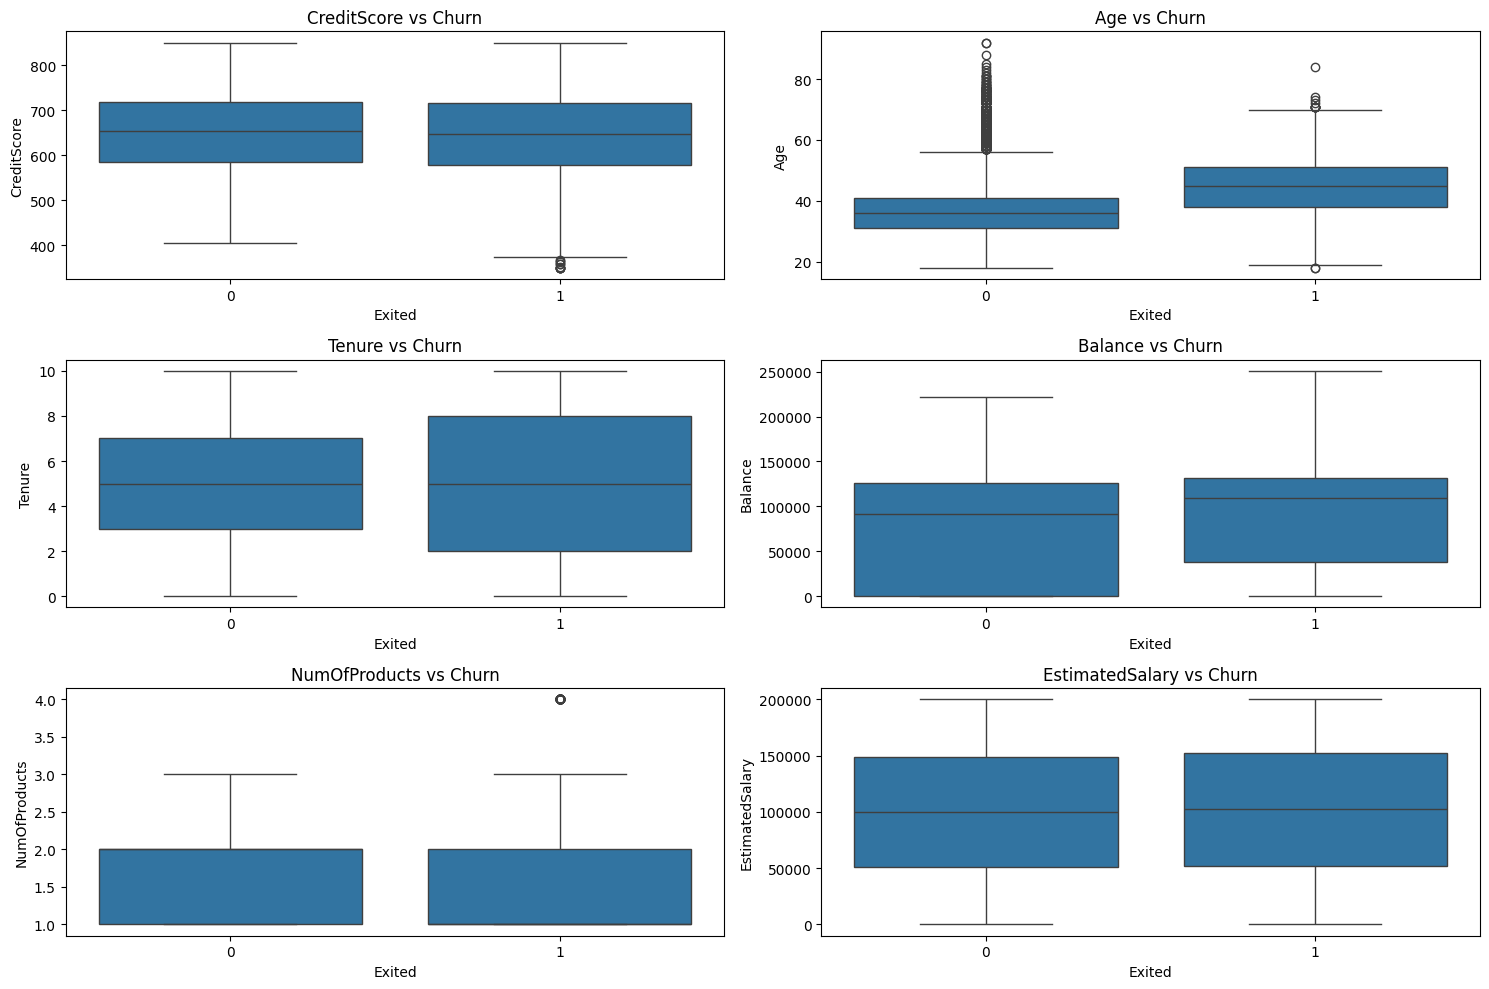

In [33]:
# Boxplot to detect outliers in numerical features
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='Exited', y=col, data=df)
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()

In [38]:
# Function to count outliers using IQR
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return len(outliers)

# Copy dataframe
df_treated = df.copy()

# Treat outliers with median imputation
for col in ['CreditScore', 'Age', 'NumOfProducts']:
    # Calculate IQR and bounds
    Q1, Q3 = df_treated[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with the median
    median_val = df_treated[col].median()
    df_treated[col] = df_treated[col].apply(lambda x: median_val if x < lower_bound or x > upper_bound else x)

# Check outliers after treatment
print("\n### Number of Outliers After Treatment ###")
for col in ['CreditScore', 'Age', 'NumOfProducts']:
    outlier_count = count_outliers(df_treated, col)
    print(f"{col}: {outlier_count} outliers")

# Update df for further processing
df = df_treated
print(f"New dataset shape after treatment: {df.shape}")



### Number of Outliers After Treatment ###
CreditScore: 0 outliers
Age: 0 outliers
NumOfProducts: 0 outliers
New dataset shape after treatment: (9996, 11)


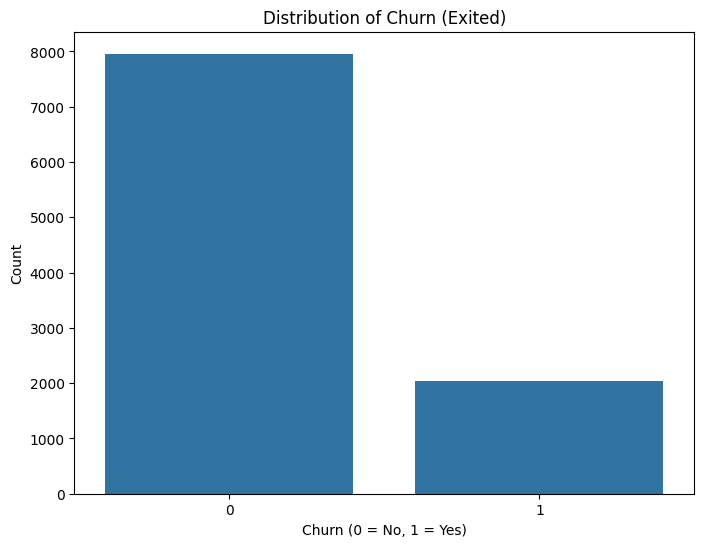

In [39]:
#isualize target variable distribution
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Exited')
plt.title("Distribution of Churn (Exited)")
plt.xlabel("Churn (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

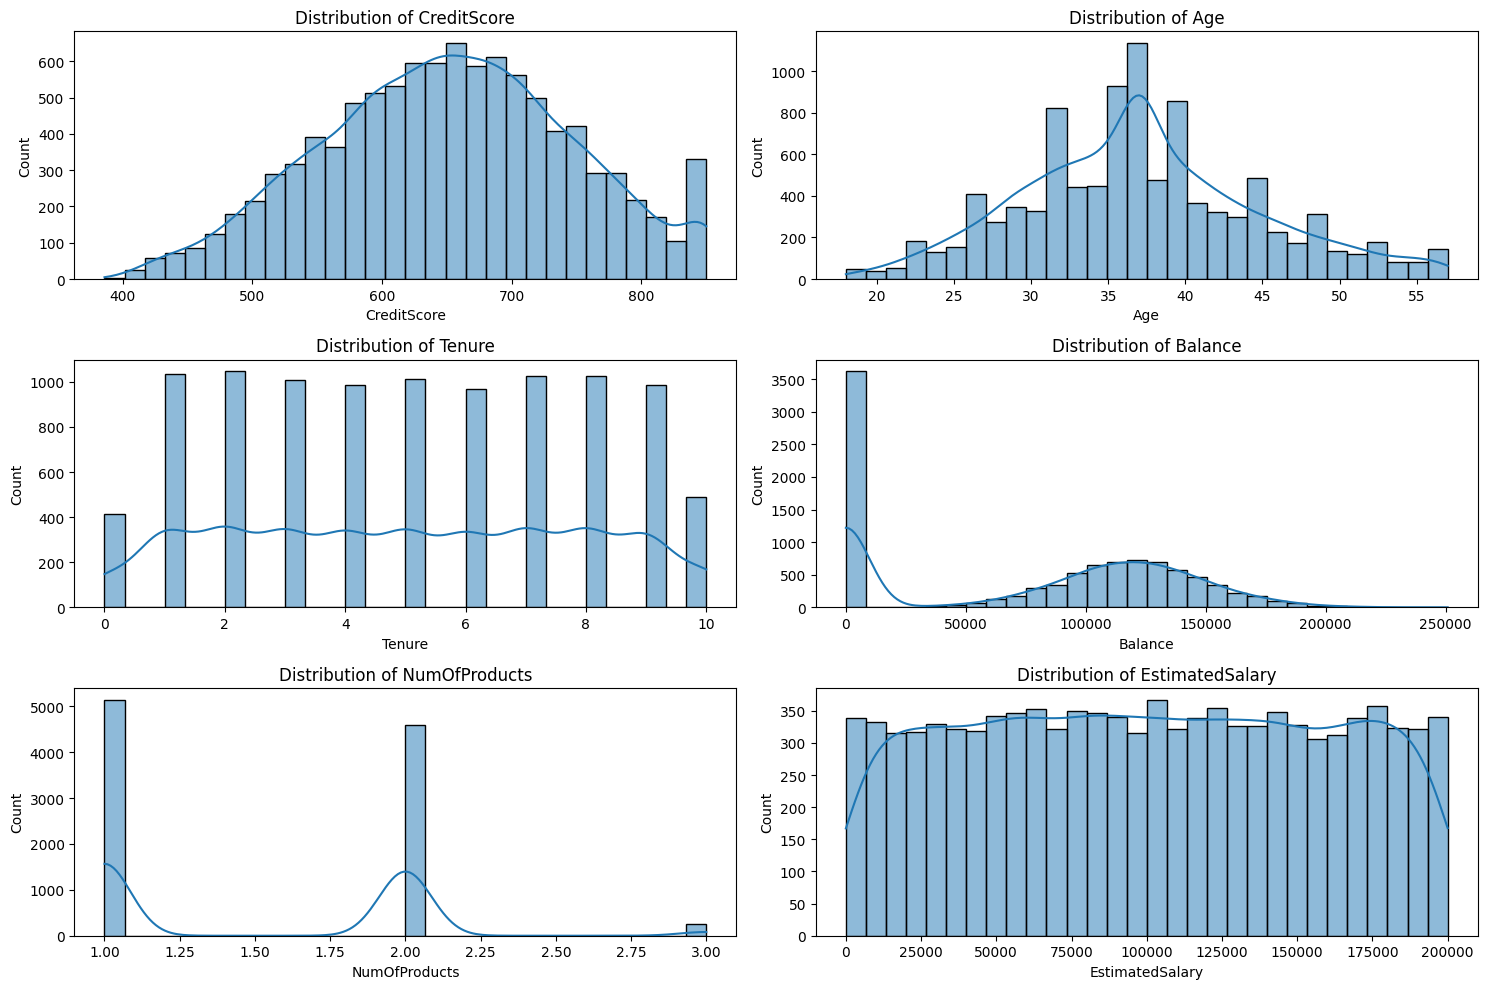

In [40]:
# Distribution of numerical features
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

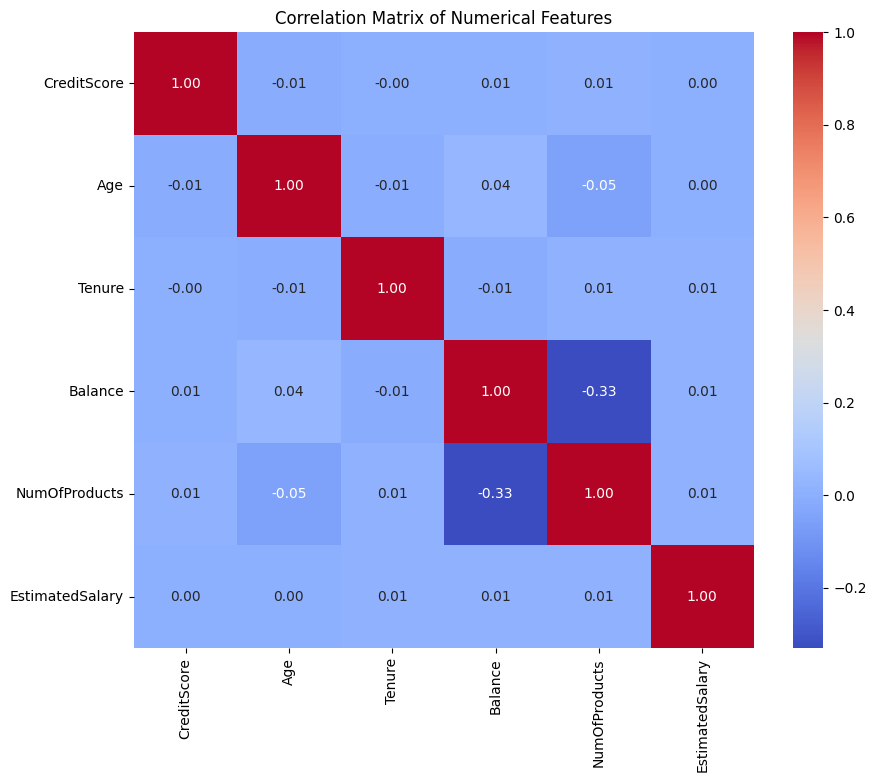

In [42]:
# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

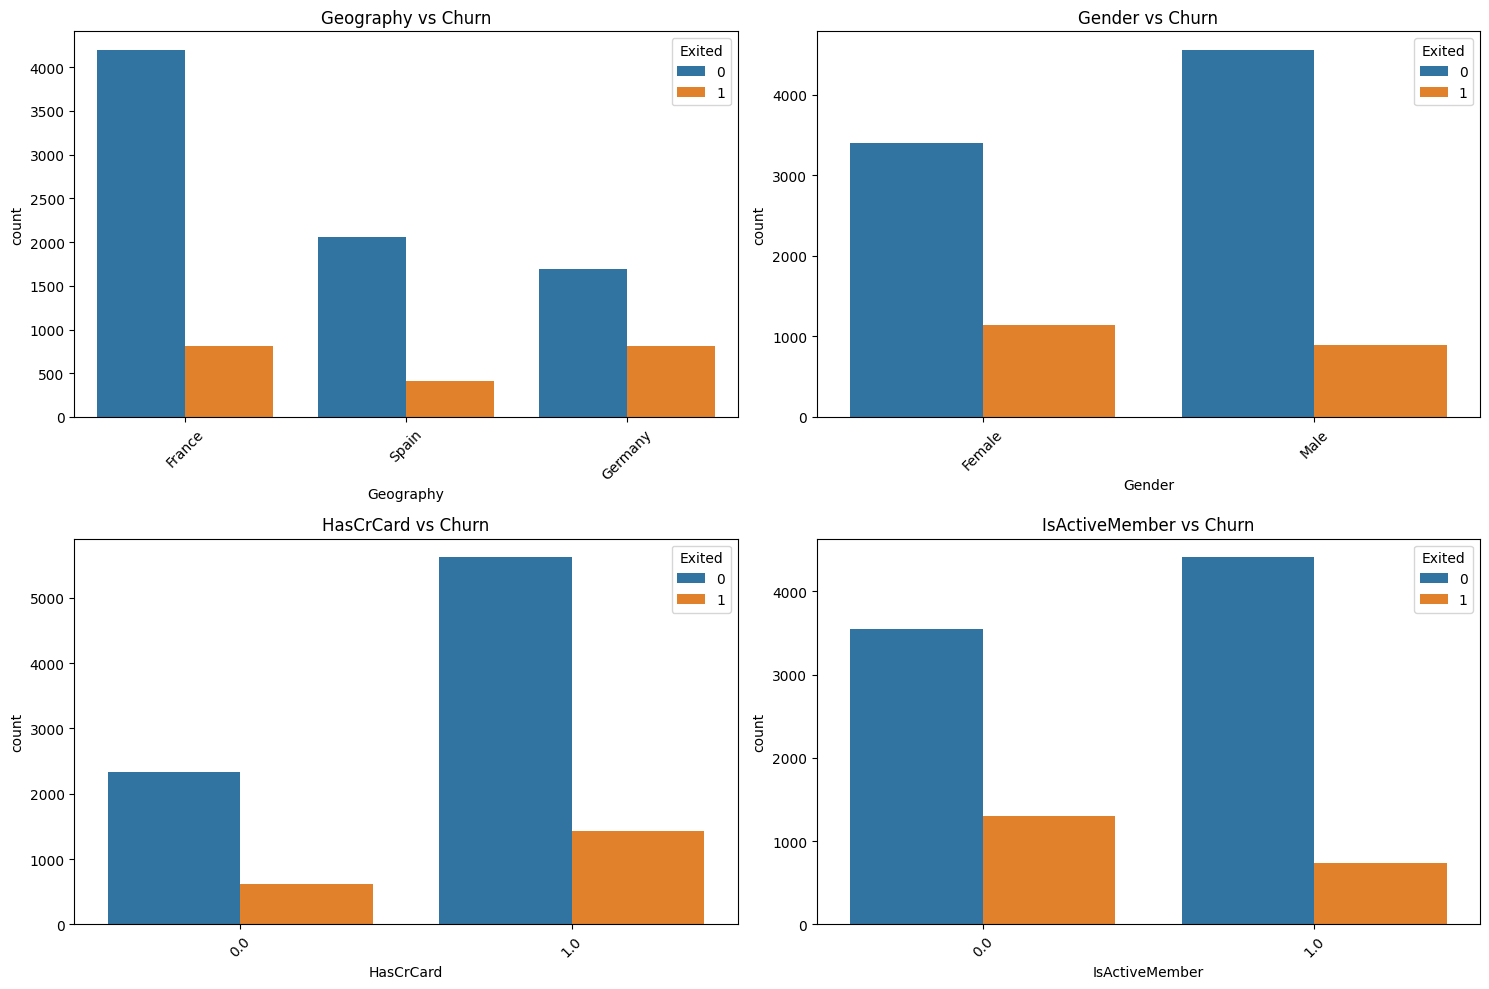

In [43]:
# Categorical features analysis
categorical_cols = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
plt.figure(figsize=(15, 10))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='Exited', data=df)
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# Feature engineering
df['Balance_to_Salary'] = df['Balance'] / df['EstimatedSalary']
df['Tenure_to_Age'] = df['Tenure'] / df['Age']
df['Balance_Age_Interaction'] = df['Balance'] * df['Age']
df['Products_Age_Interaction'] = df['NumOfProducts'] * df['Age']

In [45]:
# Encode categorical variables
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
print("\nFeature engineering completed.")


Feature engineering completed.


In [46]:
# Split data into features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

In [47]:
# Split data into training and test sets (no oversampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [48]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"\nPCA applied: Reduced to {X_train_pca.shape[1]} components.")
print(f"Explained variance ratio: {sum(pca.explained_variance_ratio_):.4f}")


PCA applied: Reduced to 11 components.
Explained variance ratio: 0.9584


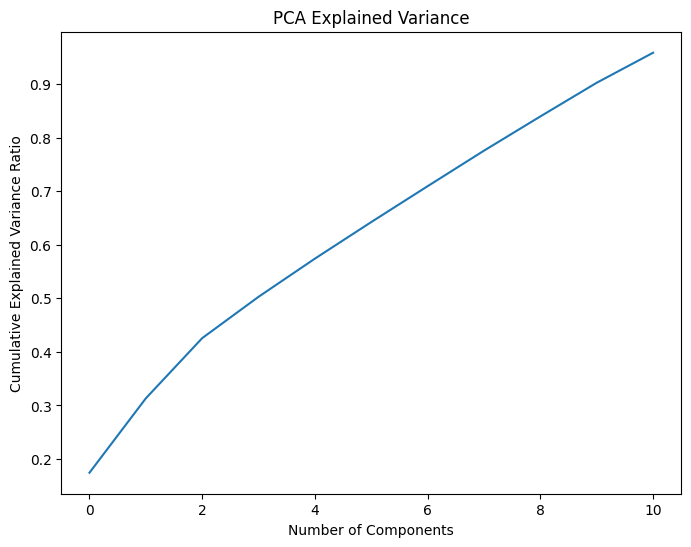

In [50]:
# Visualize explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Explained Variance')
plt.show()

In [51]:
# Hyperparameter tuning for base models with timing and acceleration
print("\n### Hyperparameter Tuning ###")


### Hyperparameter Tuning ###


In [52]:
start_time = time.time()
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
rf_grid.fit(X_train_pca, y_train)
best_rf = rf_grid.best_estimator_
rf_tuning_time = time.time() - start_time
print(f"Random Forest Tuning Time: {rf_tuning_time:.2f} seconds")
print("Random Forest Tuning Results:")
rf_results = pd.DataFrame(rf_grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(rf_results)
print("Best Random Forest Params:", rf_grid.best_params_)
print(f"Best Random Forest Accuracy: {rf_grid.best_score_:.4f}")

Random Forest Tuning Time: 214.53 seconds
Random Forest Tuning Results:
                                               params  mean_test_score  \
0   {'max_depth': 10, 'min_samples_split': 2, 'n_e...         0.841421   
1   {'max_depth': 10, 'min_samples_split': 2, 'n_e...         0.841046   
2   {'max_depth': 10, 'min_samples_split': 5, 'n_e...         0.841171   
3   {'max_depth': 10, 'min_samples_split': 5, 'n_e...         0.842296   
4   {'max_depth': 20, 'min_samples_split': 2, 'n_e...         0.840172   
5   {'max_depth': 20, 'min_samples_split': 2, 'n_e...         0.839547   
6   {'max_depth': 20, 'min_samples_split': 5, 'n_e...         0.839671   
7   {'max_depth': 20, 'min_samples_split': 5, 'n_e...         0.839421   
8   {'max_depth': None, 'min_samples_split': 2, 'n...         0.837795   
9   {'max_depth': None, 'min_samples_split': 2, 'n...         0.838295   
10  {'max_depth': None, 'min_samples_split': 5, 'n...         0.840171   
11  {'max_depth': None, 'min_samples_spl

In [53]:
# Gradient Boosting (LightGBM, CPU-only, with class weights)
start_time = time.time()
gb_param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3]
}
gb_grid = GridSearchCV(LGBMClassifier(random_state=42, class_weight='balanced'), gb_param_grid, cv=5, scoring='accuracy', n_jobs=1, return_train_score=True)
gb_grid.fit(X_train_pca, y_train)
best_gb = gb_grid.best_estimator_
gb_tuning_time = time.time() - start_time
print(f"Gradient Boosting (LightGBM) Tuning Time: {gb_tuning_time:.2f} seconds")
print("Gradient Boosting Tuning Results:")
gb_results = pd.DataFrame(gb_grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(gb_results)
print("Best Gradient Boosting Params:", gb_grid.best_params_)
print(f"Best Gradient Boosting Accuracy: {gb_grid.best_score_:.4f}")

[LightGBM] [Info] Number of positive: 1303, number of negative: 5093
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 6396, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [54]:
# XGBoost (GPU acceleration with device='cuda')
start_time = time.time()
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}
xgb_grid = GridSearchCV(XGBClassifier(random_state=42, device='cuda'), xgb_param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
xgb_grid.fit(X_train_pca, y_train)
best_xgb = xgb_grid.best_estimator_
xgb_tuning_time = time.time() - start_time
print(f"XGBoost Tuning Time: {xgb_tuning_time:.2f} seconds")
print("XGBoost Tuning Results:")
xgb_results = pd.DataFrame(xgb_grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(xgb_results)
print("Best XGBoost Params:", xgb_grid.best_params_)
print(f"Best XGBoost Accuracy: {xgb_grid.best_score_:.4f}")

XGBoost Tuning Time: 11.82 seconds
XGBoost Tuning Results:
                                              params  mean_test_score  \
0  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.808905   
1  {'learning_rate': 0.01, 'max_depth': 3, 'n_est...         0.826664   
2  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.825663   
3  {'learning_rate': 0.01, 'max_depth': 5, 'n_est...         0.838295   
4  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.842297   
5  {'learning_rate': 0.1, 'max_depth': 3, 'n_esti...         0.844173   
6  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.844173   
7  {'learning_rate': 0.1, 'max_depth': 5, 'n_esti...         0.840171   

   std_test_score  
0        0.002710  
1        0.006038  
2        0.004528  
3        0.005698  
4        0.005316  
5        0.004895  
6        0.006301  
7        0.006053  
Best XGBoost Params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best XGBoost Accuracy:

In [55]:
start_time = time.time()
catboost_param_grid = {  # Defined here to fix NameError
    'iterations': [100],
    'learning_rate': [0.1],
    'depth': [3]
}
catboost_grid = GridSearchCV(CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced'), catboost_param_grid, cv=5, scoring='accuracy', n_jobs=1, return_train_score=True)
catboost_grid.fit(X_train_pca, y_train)
best_catboost = catboost_grid.best_estimator_
catboost_tuning_time = time.time() - start_time
print(f"CatBoost Tuning Time: {catboost_tuning_time:.2f} seconds")
print("CatBoost Tuning Results:")
catboost_results = pd.DataFrame(catboost_grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
print(catboost_results)
print("Best CatBoost Params:", catboost_grid.best_params_)
print(f"Best CatBoost Accuracy: {catboost_grid.best_score_:.4f}")

CatBoost Tuning Time: 1.50 seconds
CatBoost Tuning Results:
                                              params  mean_test_score  \
0  {'depth': 3, 'iterations': 100, 'learning_rate...         0.758254   

   std_test_score  
0        0.008607  
Best CatBoost Params: {'depth': 3, 'iterations': 100, 'learning_rate': 0.1}
Best CatBoost Accuracy: 0.7583


In [56]:
# # SVM (CPU-based, no GPU in scikit-learn)
# start_time = time.time()
# svm_param_grid = {
#     'C': [0.1, 1, 10],
#     'kernel': ['rbf', 'linear']
# }
# svm_grid = GridSearchCV(SVC(probability=True, random_state=42), svm_param_grid, cv=5, scoring='accuracy', n_jobs=-1, return_train_score=True)
# svm_grid.fit(X_train_pca, y_train)
# best_svm = svm_grid.best_estimator_
# svm_tuning_time = time.time() - start_time
# print(f"SVM Tuning Time: {svm_tuning_time:.2f} seconds")
# print("SVM Tuning Results:")
# svm_results = pd.DataFrame(svm_grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
# print(svm_results)
# print("Best SVM Params:", svm_grid.best_params_)
# print(f"Best SVM Accuracy: {svm_grid.best_score_:.4f}")

In [57]:
base_models = [
    ('rf', best_rf),
    ('gb', best_gb),
    ('xgb', best_xgb),
    ('catboost', best_catboost)
   # (#'svm', best_svm)
]

In [58]:
# Define meta-model
meta_model = LogisticRegression(max_iter=1000)

In [59]:
# Create stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

In [60]:
# Train and evaluate stacking model
stacking_model.fit(X_train_pca, y_train)
y_pred_stacking = stacking_model.predict(X_test_pca)
y_pred_prob_stacking = stacking_model.predict_proba(X_test_pca)[:, 1]

[LightGBM] [Info] Number of positive: 1629, number of negative: 6367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 7996, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [61]:
# Evaluation metrics for Stacking
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
f1_stacking = f1_score(y_test, y_pred_stacking)
roc_auc_stacking = roc_auc_score(y_test, y_pred_prob_stacking)

print("\nStacking Model Performance on Test Set:")
print(f"Accuracy: {accuracy_stacking:.4f}")
print(f"F1 Score: {f1_stacking:.4f}")
print(f"ROC AUC: {roc_auc_stacking:.4f}")


Stacking Model Performance on Test Set:
Accuracy: 0.8445
F1 Score: 0.5323
ROC AUC: 0.8428


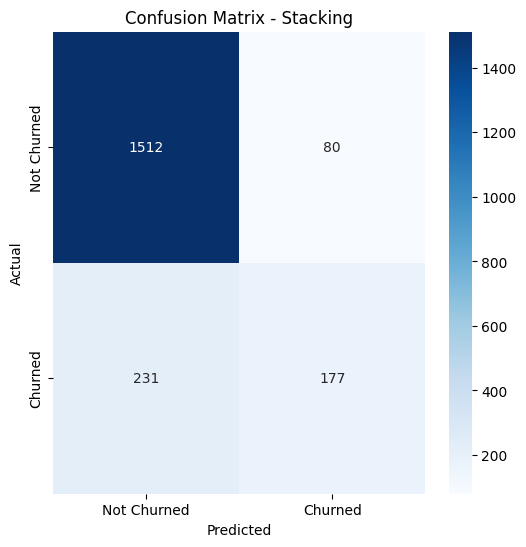

In [62]:
# Confusion Matrix for Stacking
conf_matrix = confusion_matrix(y_test, y_pred_stacking)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
plt.title("Confusion Matrix - Stacking")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

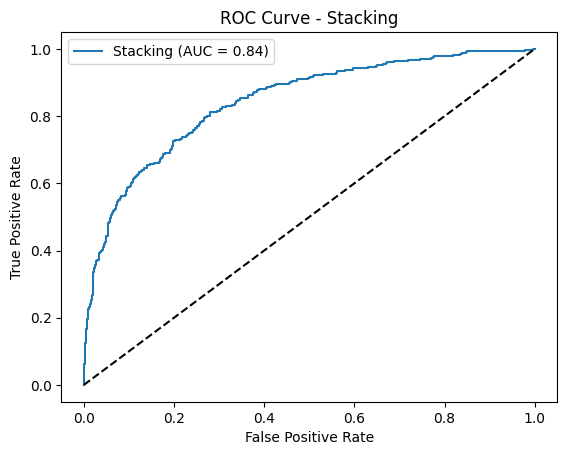

In [63]:
# ROC Curve for Stacking
fpr, tpr, _ = roc_curve(y_test, y_pred_prob_stacking)
plt.plot(fpr, tpr, label=f"Stacking (AUC = {roc_auc_stacking:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Stacking")
plt.legend()
plt.show()

In [64]:
models = {
    "Random Forest": best_rf,
    "Gradient Boosting": best_gb,
    "XGBoost": best_xgb,
    #"SVM": best_svm,
    "Stacking": stacking_model,
    'catboost' : best_catboost

}


### Model Training and Evaluation ###
Random Forest Training Time: 6.10 seconds


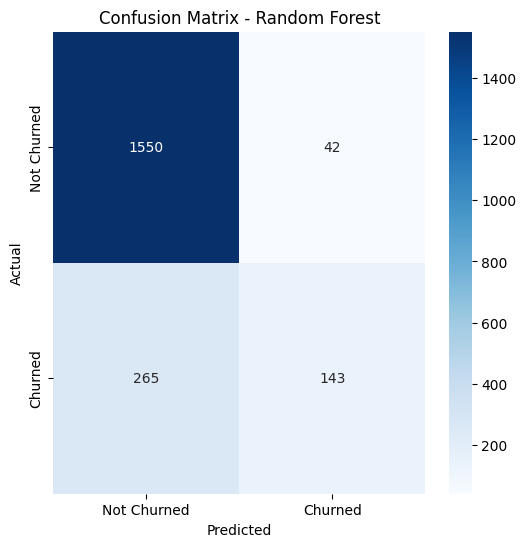

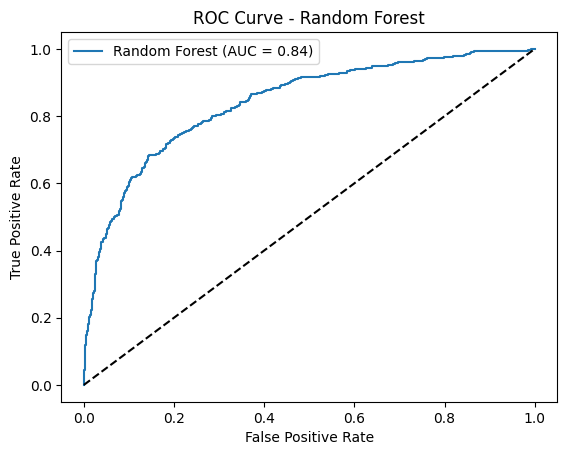

[LightGBM] [Info] Number of positive: 1629, number of negative: 6367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 7996, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

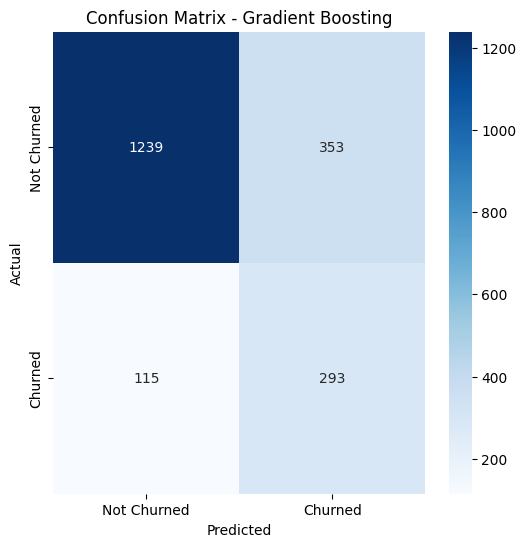

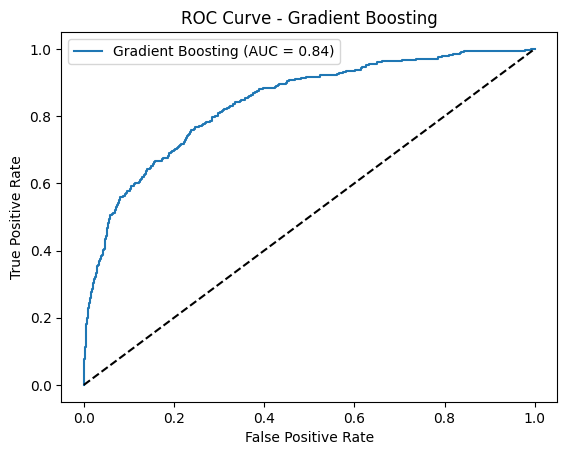

XGBoost Training Time: 0.25 seconds


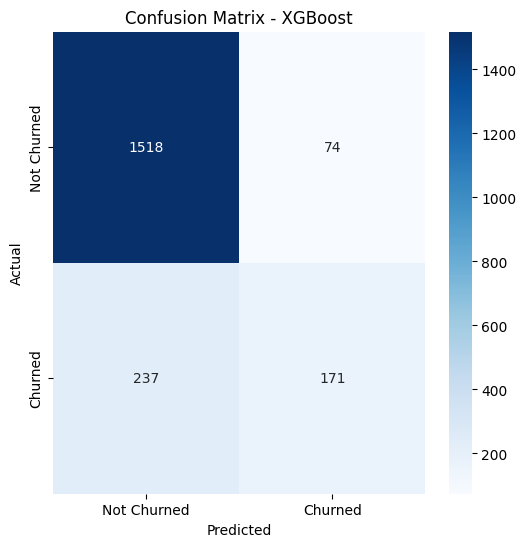

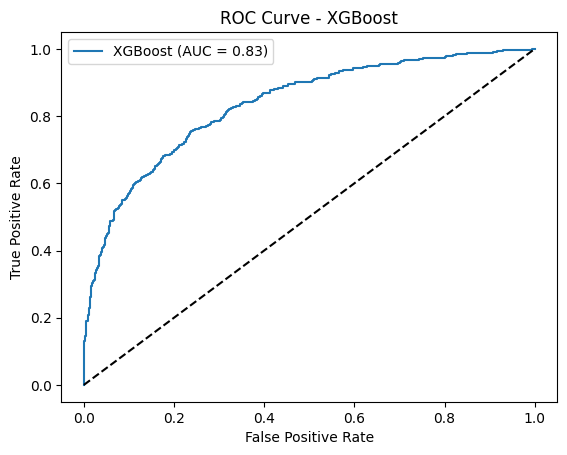

[LightGBM] [Info] Number of positive: 1629, number of negative: 6367
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 7996, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

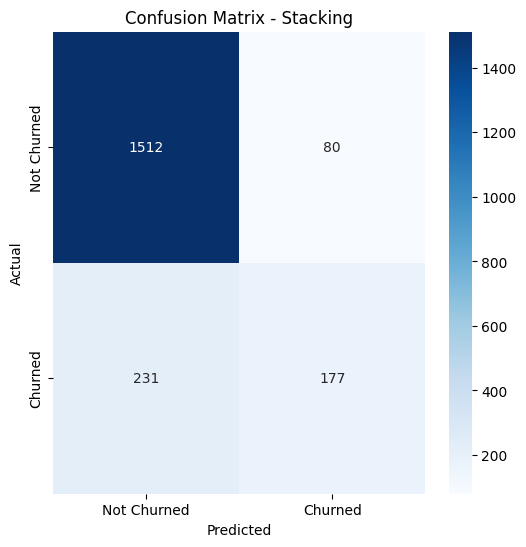

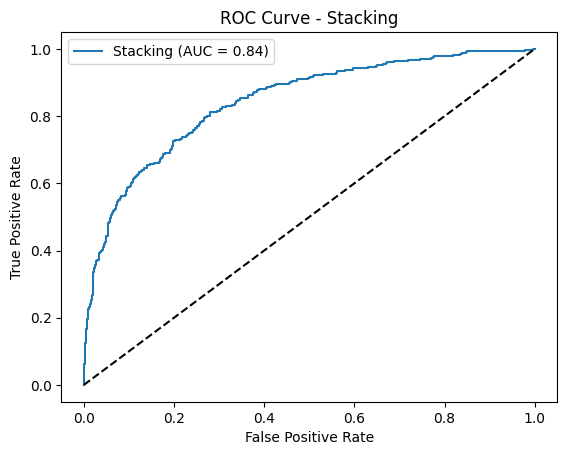

catboost Training Time: 0.23 seconds


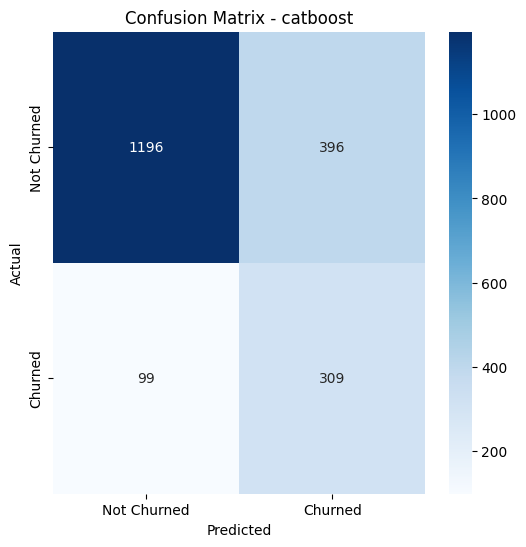

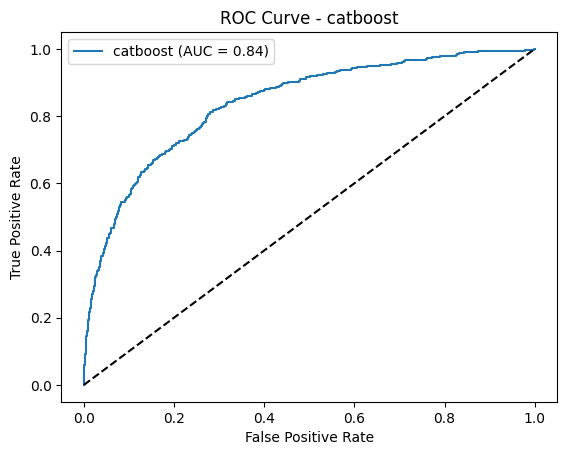

In [65]:
print("\n### Model Training and Evaluation ###")
results = {}
training_times = {}
for name, model in models.items():
    start_time = time.time()
    model.fit(X_train_pca, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time

    y_pred = model.predict(X_test_pca)
    y_pred_prob = model.predict_proba(X_test_pca)[:, 1]

    # Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    results[name] = {
        "Accuracy": accuracy,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

    print(f"{name} Training Time: {training_time:.2f} seconds")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

In [66]:
# Display results
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                   Accuracy  F1 Score   ROC AUC
Random Forest        0.8465  0.482293  0.840599
Gradient Boosting    0.7660  0.555977  0.839727
XGBoost              0.8445  0.523737  0.834901
Stacking             0.8445  0.532331  0.842795
catboost             0.7525  0.555256  0.839242


In [67]:
#Display training times
print("\nTraining Times Summary:")
for name, t in training_times.items():
    print(f"{name}: {t:.2f} seconds")


Training Times Summary:
Random Forest: 6.10 seconds
Gradient Boosting: 0.16 seconds
XGBoost: 0.25 seconds
Stacking: 31.98 seconds
catboost: 0.23 seconds


In [68]:
joblib.dump(stacking_model, '/content/stacking.pkl')

['/content/stacking.pkl']

In [74]:

joblib.dump(scaler, '/content/scaler.pkl')

['/content/scaler.pkl']

In [75]:
joblib.dump(pca, '/content/pca.pkl')
joblib.dump(X_train.columns.tolist(), '/content/feature_names.pkl')

['/content/feature_names.pkl']

In [76]:
# SHAP Analysis for background data
background_data = X_train_pca[:100]  # Sample 100 rows of PCA-transformed training data
joblib.dump(background_data, '/content/background_data.pkl')

['/content/background_data.pkl']

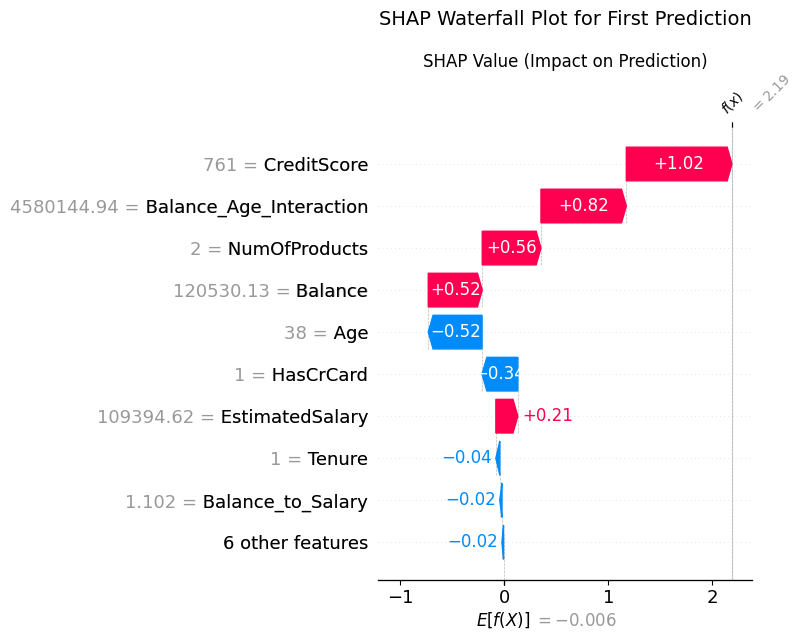

In [77]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Create a single waterfall plot with proper formatting
plt.figure(figsize=(8, 6))
shap.plots.waterfall(shap_values[0], show=False)

# Customize the plot
plt.title("SHAP Waterfall Plot for First Prediction", fontsize=14, pad=20)
plt.xlabel("SHAP Value (Impact on Prediction)", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()  #
plt.show()
